# Energy Prediction - Knowledge Transfer in the Form of Data
In our previous notebook, we illustrated data modeling using TransBEAM. We developed two models - Random Forest and a Feed-Forward Network and analyzed their performance. The next major usecase of TransBEAM lies in its ability to transfer knoweledge across the models. Why we might need it? There are numerous reasons. For instance, it is hard to gather data every time for every building at fine-granularity and that makes some serious impact on the scalability and real-world deployment of any data-driven model. For those scenarios, an existing trained model could be a good starting point. The already trained model can be fine-tuned and adapted to the field data from the building of interest. 

In this notebook, we will explore one such knowledge transfer - knowledge transfer from the data generated by a theoretical model to the model that will be trained on the field data. In this example, the knowledge transfer will happen in the form of data samples. We will pick samples from the simulation data in such a way that it helps the model in finding diverse scenarios which the model otherwise would not have experienced in its limited field data. For this example, we will use TrAdaBoost for data transfer.

## Initial Setup

In [ ]:
import sys
sys.path.append('../')

In [2]:
import itertools
import numpy as np
import pandas as pd 

from sklearn.base import clone
from sklearn.utils.validation import _num_samples

import matplotlib.pyplot as plt
from transBEAM.utils import data_handler
from transBEAM.models import preprocessor, models, tl

## Data Loading and Preprocessing

#### Step-1: Initiate the Data Handler

In [3]:
# process the data
building_dh = data_handler.TimeSeriesDataHandler()

#### Step-2: Load the Data (Source)
TransBEAM can accept any type of time series data in the pandas DataFrame format. One can easily load the data using pandas DataFrame for next steps.

In [4]:
df = pd.read_csv('./sample_data/sim_data.csv', usecols=['Date', 'Time', 'Temperature', 'Electricity'])
df['Date'] = df['Date'] + '-2020'
df

,Date,Time,Electricity,Temperature
0,01-01-2020,01:00,122.300003,-2.0
1,01-01-2020,02:00,136.695892,-3.0
2,01-01-2020,03:00,144.397583,-3.0
3,01-01-2020,04:00,149.712418,-3.0
4,01-01-2020,05:00,145.835617,-3.0
...,...,...,...,...
8755,12-31-2020,20:00,111.436920,NaN
8756,12-31-2020,21:00,136.245880,NaN
8757,12-31-2020,22:00,136.358841,NaN
8758,12-31-2020,23:00,137.670425,NaN


#### Step-3: Data Preprocessing (Source)
TimeSeriesDataHandler is a class to quickly and easily process the time series data. After data processing, the data can easily be accessed using the function `get_data()`

In [5]:
b_name = 'source'
building_dh.add_data(df, b_name)
building_dh.add_datetime(b_name, dt_cols=['Date', 'Time'], dt_format='%m-%d-%Y %H:%M')
building_dh.add_static_features(b_name)
building_dh.add_shift_cols(b_name, col_names=["Temperature"], shift_by=[1])
building_dh.dropna(b_name)

In [6]:
df_source = building_dh.get_data('source')
df_source.head()

,Date,Time,Electricity,Temperature,DayOfWeek,Weekday,HourOfDay,WorkHour,Month,PrevTemperature
datetime,,,,,,,,,,
2020-01-01 02:00:00,01-01-2020,02:00,136.695892,-3.0,2,1,2,0,1,-2.0
2020-01-01 03:00:00,01-01-2020,03:00,144.397583,-3.0,2,1,3,0,1,-3.0
2020-01-01 04:00:00,01-01-2020,04:00,149.712418,-3.0,2,1,4,0,1,-3.0
2020-01-01 05:00:00,01-01-2020,05:00,145.835617,-3.0,2,1,5,0,1,-3.0
2020-01-01 06:00:00,01-01-2020,06:00,117.948349,2.0,2,1,6,0,1,-3.0


#### Step-4: Load the Data (Target)
TransBEAM can accept any type of time series data in the pandas DataFrame format. One can easily load the data using pandas DataFrame for next steps.

In [7]:
df = pd.read_csv('./sample_data/field_data.csv', usecols=['Date', 'Time', 'Temperature', 'Electricity'])
df['Date'] = df['Date'] + '-2020'
df

,Date,Time,Temperature,Electricity
0,01-01-2020,01:00,-2.0,205.28125
1,01-01-2020,02:00,-3.0,197.84375
2,01-01-2020,03:00,-3.0,210.50000
3,01-01-2020,04:00,-3.0,201.25000
4,01-01-2020,05:00,-3.0,209.87500
...,...,...,...,...
8755,12-31-2020,20:00,1.0,79.12500
8756,12-31-2020,21:00,1.0,85.75000
8757,12-31-2020,22:00,1.0,66.09375
8758,12-31-2020,23:00,0.5,76.03125


#### Step-5: Data Preprocessing (Target)
TimeSeriesDataHandler is a class to quickly and easily process the time series data. After data processing, the data can easily be accessed using the function `get_data()`

In [8]:
b_name = 'target'
building_dh.add_data(df, b_name)
building_dh.add_datetime(b_name, dt_cols=['Date', 'Time'], dt_format='%m-%d-%Y %H:%M')
building_dh.add_static_features(b_name)
building_dh.add_shift_cols(b_name, col_names=["Temperature"], shift_by=[1])
building_dh.dropna(b_name)

In [9]:
df_target = building_dh.get_data('target')
df_target.head()

,Date,Time,Temperature,Electricity,DayOfWeek,Weekday,HourOfDay,WorkHour,Month,PrevTemperature
datetime,,,,,,,,,,
2020-01-01 02:00:00,01-01-2020,02:00,-3.0,197.84375,2,1,2,0,1,-2.0
2020-01-01 03:00:00,01-01-2020,03:00,-3.0,210.50000,2,1,3,0,1,-3.0
2020-01-01 04:00:00,01-01-2020,04:00,-3.0,201.25000,2,1,4,0,1,-3.0
2020-01-01 05:00:00,01-01-2020,05:00,-3.0,209.87500,2,1,5,0,1,-3.0
2020-01-01 06:00:00,01-01-2020,06:00,2.0,205.62500,2,1,6,0,1,-3.0


## Data Modeling
In this section, we will illustrate data modeling with the help of two already implemented models: Random Forest and Feed-Forward Neural Network. Before training the model, it is important that we seperate out features and the target model. In the current model, the library doesn't support sequential models.  

In [10]:
X_cols = ['Temperature', 'DayOfWeek', 'Weekday', 'HourOfDay', 'WorkHour', 'Month', 'PrevTemperature']
y_col = 'Electricity'

all_cols = X_cols + [y_col]

#### Step-6: Split and Normalize the Data

In [11]:
dp = preprocessor.DataPreprocessor()
train, test = dp.data_split(df_target[all_cols], train_size=0.8)

source_norm = dp.normalize_data(df_source[all_cols])
target_norm = dp.normalize_data(df_target[all_cols])

---------------- Size of Training Data:  0.8 % -------------------------
Size of Training Data:  (7004, 8)
Size of Testing Data:  (1752, 8)


#### Step-7: Train the Model

In [12]:
n_iterations = 30
it_model = tl.InstanceTransfer(n_iterations=n_iterations)
it_model.fit(source_norm[X_cols], source_norm[y_col], target_norm[X_cols], target_norm[y_col])

Text(0.5, 1.0, 'P-values [sample wise]')

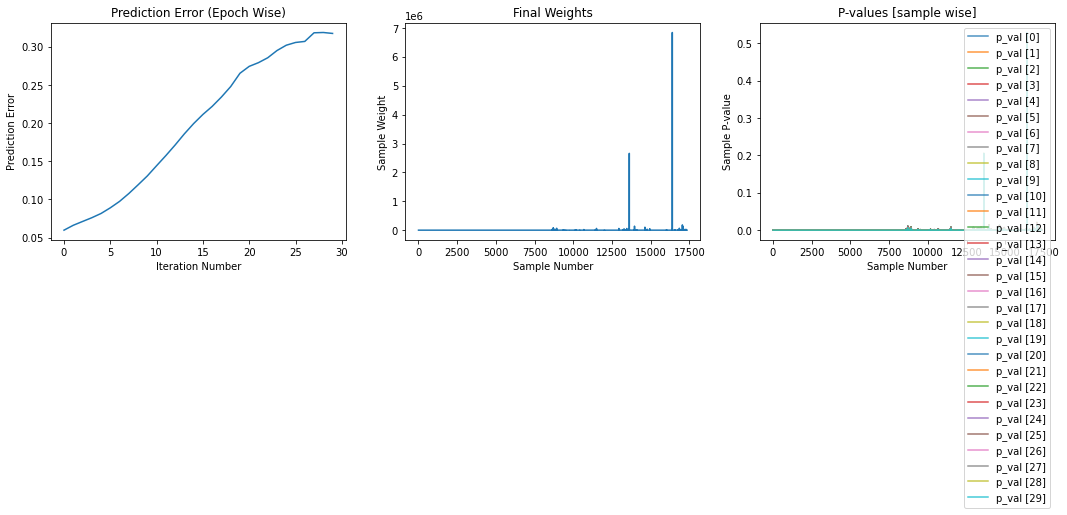

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

ax = axes[0]
ax.plot(it_model.error)
ax.set_xlabel("Iteration Number")
ax.set_ylabel("Prediction Error")
ax.set_title("Prediction Error (Epoch Wise)")

ax = axes[1]
final_weights = it_model.weights
ax.plot(final_weights)
ax.set_xlabel("Sample Number")
ax.set_ylabel("Sample Weight")
ax.set_title("Final Weights")

ax = axes[2]
df_P = pd.DataFrame(it_model.P_values, index=["p_val [" + str(i) + "]" for i in range(n_iterations)], columns=range(len(final_weights)))
df_P.T.plot(ax=ax, alpha=0.8)
ax.set_xlabel("Sample Number")
ax.set_ylabel("Sample P-value")
ax.set_title("P-values [sample wise]")

#### Step-8: Predict on Test Set

In [14]:
test_norm = dp.normalize_data(test)
y_pred = it_model.predict(test_norm[X_cols])

In [15]:
df_predictions = dp.inverse_transform(test_norm, y_pred, y_col)

#### Step-9: Visualize the Predictions

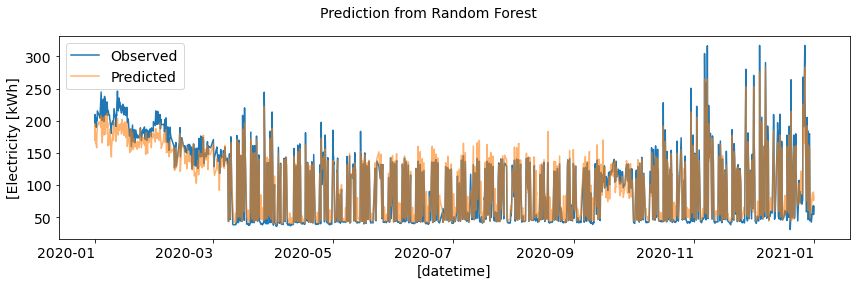

In [16]:
fontsize = 14
fig = plt.figure(figsize=(12, 4))
ax = fig.gca()

test["Electricity"].plot(ax=ax, label='Observed', fontsize=fontsize)
df_predictions["Electricity"].plot(ax=ax, alpha=0.6, label='Predicted', rot=0, fontsize=fontsize)

ax.set_xlabel("[datetime]", fontsize=fontsize)
ax.set_ylabel("[Electricity [kWh]", fontsize=fontsize)
ax.legend(fontsize=fontsize)

fig.suptitle('Prediction from Random Forest', fontsize=fontsize)
fig.tight_layout()